In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from scipy import signal
import math
import cv2

### Load images 

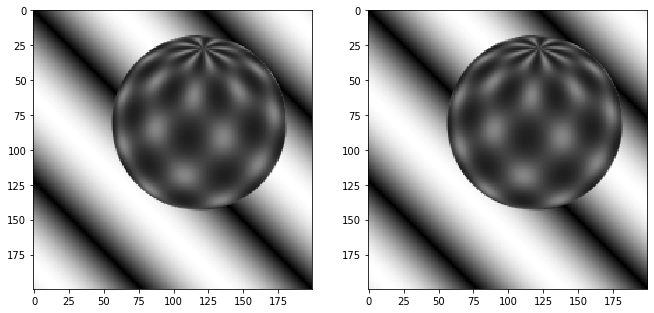

In [2]:
# Read the image and be sure it is grayscale
sphere0 = io.imread('sphere0.png')
sphere0 = rgb2gray(sphere0)

sphere1 = io.imread('sphere1.png')
sphere1 = rgb2gray(sphere1)

plt.subplots(1,2,figsize=(11,11))
plt.subplot(1,2,1)
plt.imshow(sphere0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sphere1, cmap='gray')

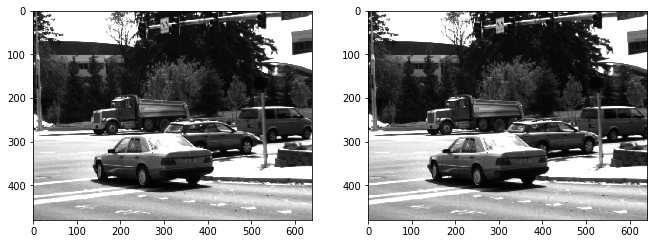

In [3]:
traffic0 = io.imread('traffic0.png')
traffic0 = rgb2gray(traffic0)

traffic1 = io.imread('traffic1.png')
traffic1 = rgb2gray(traffic1)

plt.subplots(1,2,figsize=(11,11))
plt.subplot(1,2,1)
plt.imshow(traffic0, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(traffic1, cmap='gray')

### Computing spatial partial derivative images Ix and Iy for image0
I have used sobel method, since we are allowed to use any method for computing the partial derivative's 

In [4]:
def xGradient(img1, img2):
    xFilter = np.array([[0, 0, 0],
                        [-1, 0, 1],
                        [0, 0, 0]])
    Ix1 = signal.convolve2d(img1, xFilter, mode = 'same')
    Ix2 = signal.convolve2d(img2, xFilter, mode = 'same')
    Ix = Ix1 + Ix2
    return Ix


# Calculating grdient along y direction
def yGradient(img1, img2):
    yFilter = np.array([[0, 1, 0],
                        [0, 0, 0],
                        [0, -1, 0]])
    Iy1 = signal.convolve2d(img1, yFilter, mode = 'same')
    Iy2 = signal.convolve2d(img2, yFilter, mode = 'same')
    Iy = Iy1 + Iy2
    return Iy

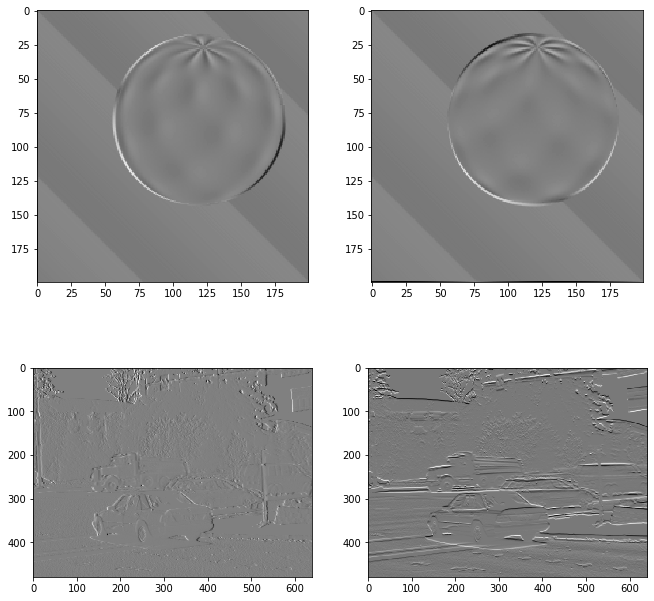

In [5]:
sphere_x = xGradient(sphere0, sphere1)
sphere_y = yGradient(sphere0, sphere1)

traffic_x = xGradient(traffic0, traffic1)
traffic_y = yGradient(traffic0, traffic1)

plt.subplots(2,2,figsize=(11,11))
plt.subplot(2,2,1)
plt.imshow(sphere_x, cmap='gray')
plt.subplot(2,2,2)
plt.imshow(sphere_y, cmap='gray')
plt.subplot(2,2,3)
plt.imshow(traffic_x, cmap='gray')
plt.subplot(2,2,4)
plt.imshow(traffic_y, cmap='gray')

### Computing temporal partial derivative It
This can be approximated by image difference im2 - im1

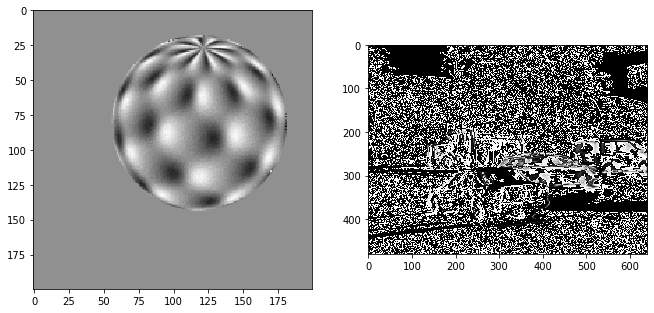

In [6]:
sphere_t = np.subtract(sphere1, sphere0)
traffic_t = np.subtract(traffic1, traffic0)

plt.subplots(1,2,figsize=(11,11))
plt.subplot(1,2,1)
plt.imshow(sphere_t, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(traffic_t, cmap='gray')

## Generating Flow field map 
###### Vector
The vectors are plotted on the image using meshgrid. This gives the direction of flow field at a given pixel.  
###### Vector Magnitude
Flow vector magnitude is calculated from it's derivatives w.r.t x and y (i.e u and v) using the formula sgrt(u^2 + v^2)
###### Color Map
The magnitude and direction are both understandable using color maps. Color denotes direction of flow at some point, intensity denotes length of displacement vector. The color map used is -

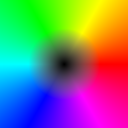

In [7]:
def flow_map (img, u, v):
    # Subsample the vector field to make it less dense 
    [rows, cols] = img.shape
    subsample = 6
    sub_u = u[0:rows:subsample, 0:cols:subsample] 
    sub_v = v[0:rows:subsample, 0:cols:subsample]
    xc = np.linspace(0, cols, sub_u.shape[1])
    yc = np.linspace(0, rows, sub_u.shape[0])
    # Locations of the vectors
    xv, yv = np.meshgrid(xc, yc)
    
    flowvector = np.zeros(u.shape)
    for i in range(flowvector.shape[0]):
        for j in range(flowvector.shape[1]):
            flowvector[i,j] = math.sqrt(u[i,j]**2 + v[i,j]**2)
    flowvector = ((flowvector-np.min(flowvector))*(1/(np.max(flowvector)-np.min(flowvector))*1.0)).astype('float')
                          
    colorModel = cv2.imread('colormodel.png')
    colorModelCenter = (colorModel.shape[0]/2, colorModel.shape[1]/2)
    res = np.zeros((u.shape[0], u.shape[1], 3), dtype=np.uint8)
    mag = np.max(np.sqrt(u**2 + v**2)) 
    if mag != 0:
        for i in range(res.shape[0]):
            for j in range(res.shape[1]):
                res[i, j] = colorModel[int(colorModelCenter[0] + (v[i, j]/mag*colorModelCenter[0])),
                                       int(colorModelCenter[1] + (u[i, j]/mag*colorModelCenter[1]))]
            
    plt.subplots(1,3,figsize=(15,15))
    plt.subplot(1,3,1)
    plt.imshow(flowvector,cmap = 'gray')
    plt.title('Flow Vector = sqrt u^2+v^2'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(img,cmap = 'gray')
    plt.title('Optical Flow as Vector Field'), plt.xticks([]), plt.yticks([])
    # Plot the vectors
    plt.quiver(xv, yv, sub_u, sub_v, color='y')
    plt.subplot(1,3,3)
    plt.imshow(res)
    plt.title('Flow with Direction & Magnitude'), plt.xticks([]), plt.yticks([])

# Lucas-Kanade Method

In [8]:
def lucas_kanade (dx, dy, dt, u, v, n):
    n = int(n/2)
    for i in range(1, u.shape[0]):
        for j in range(1, u.shape[1]):
            Ix = dx[i - n:i + n + 1, j - n:j + n + 1].flatten()
            Iy = dy[i - n:i + n + 1, j - n:j + n + 1].flatten()
            A = np.vstack((Ix, Iy)).T
            b = dt[i - n:i + n + 1, j - n:j + n + 1].flatten()
            x = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), b)
            u[i, j] = x[0]
            v[i, j] = x[1]

### Implemented on sphere using a neighborhood size of 3, 5, 11, and 21

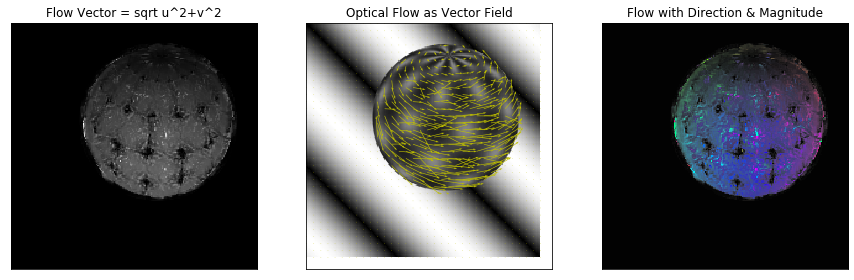

In [9]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
lucas_kanade (sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 3)
flow_map (sphere0, sphere_u, sphere_v)

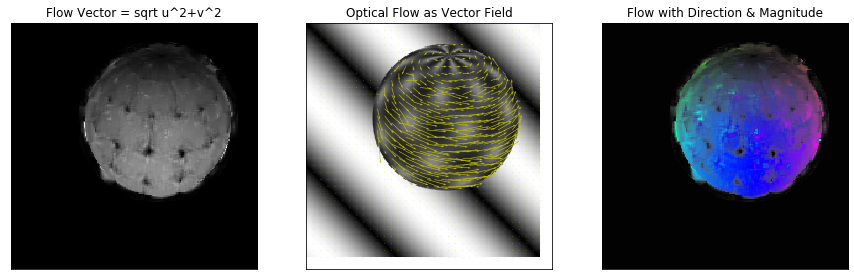

In [10]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
lucas_kanade (sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 5)
flow_map (sphere0, sphere_u, sphere_v)

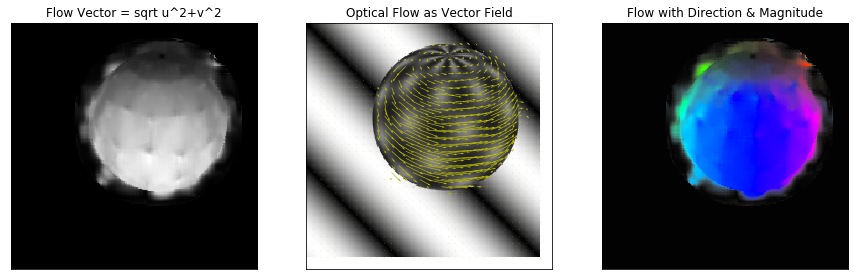

In [11]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
lucas_kanade (sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 11)
flow_map (sphere0, sphere_u, sphere_v)

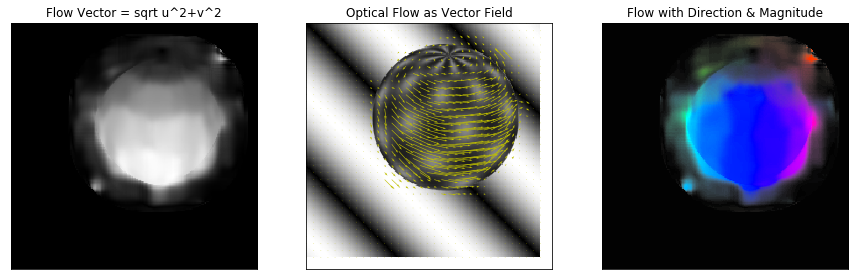

In [12]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
lucas_kanade (sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 21)
flow_map (sphere0, sphere_u, sphere_v)

### Implementing on traffic image

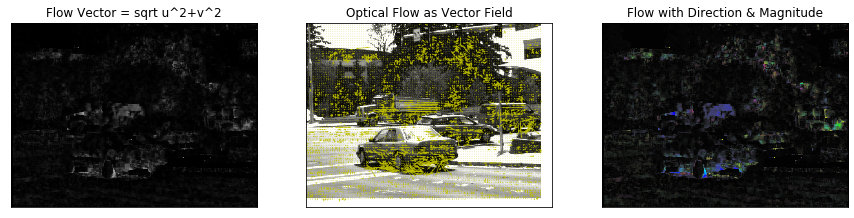

In [13]:
traffic_u = np.zeros(traffic0.shape)
traffic_v = np.zeros(traffic0.shape)
lucas_kanade (traffic_x, traffic_y, traffic_t, traffic_u, traffic_v, 9)
flow_map (traffic0, traffic_u, traffic_v)

# Horn-Schunck method

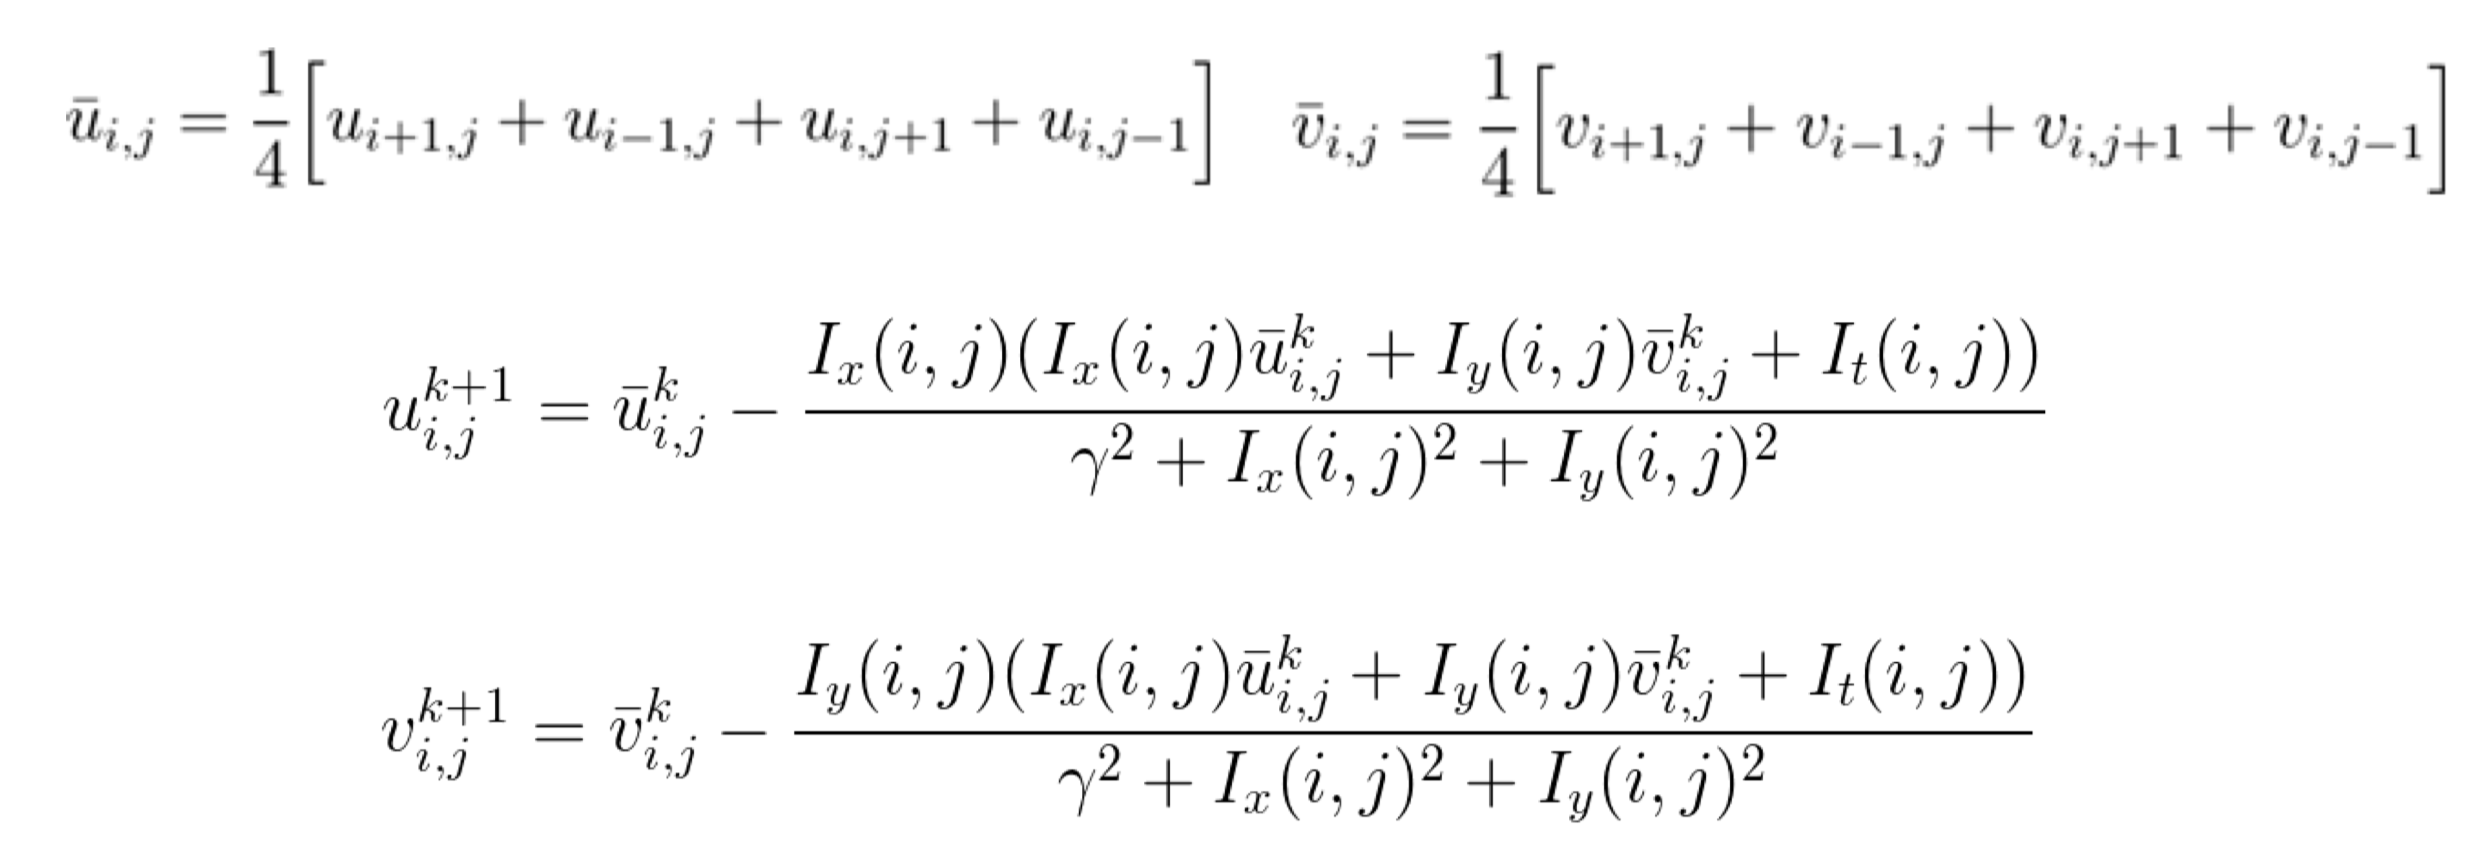

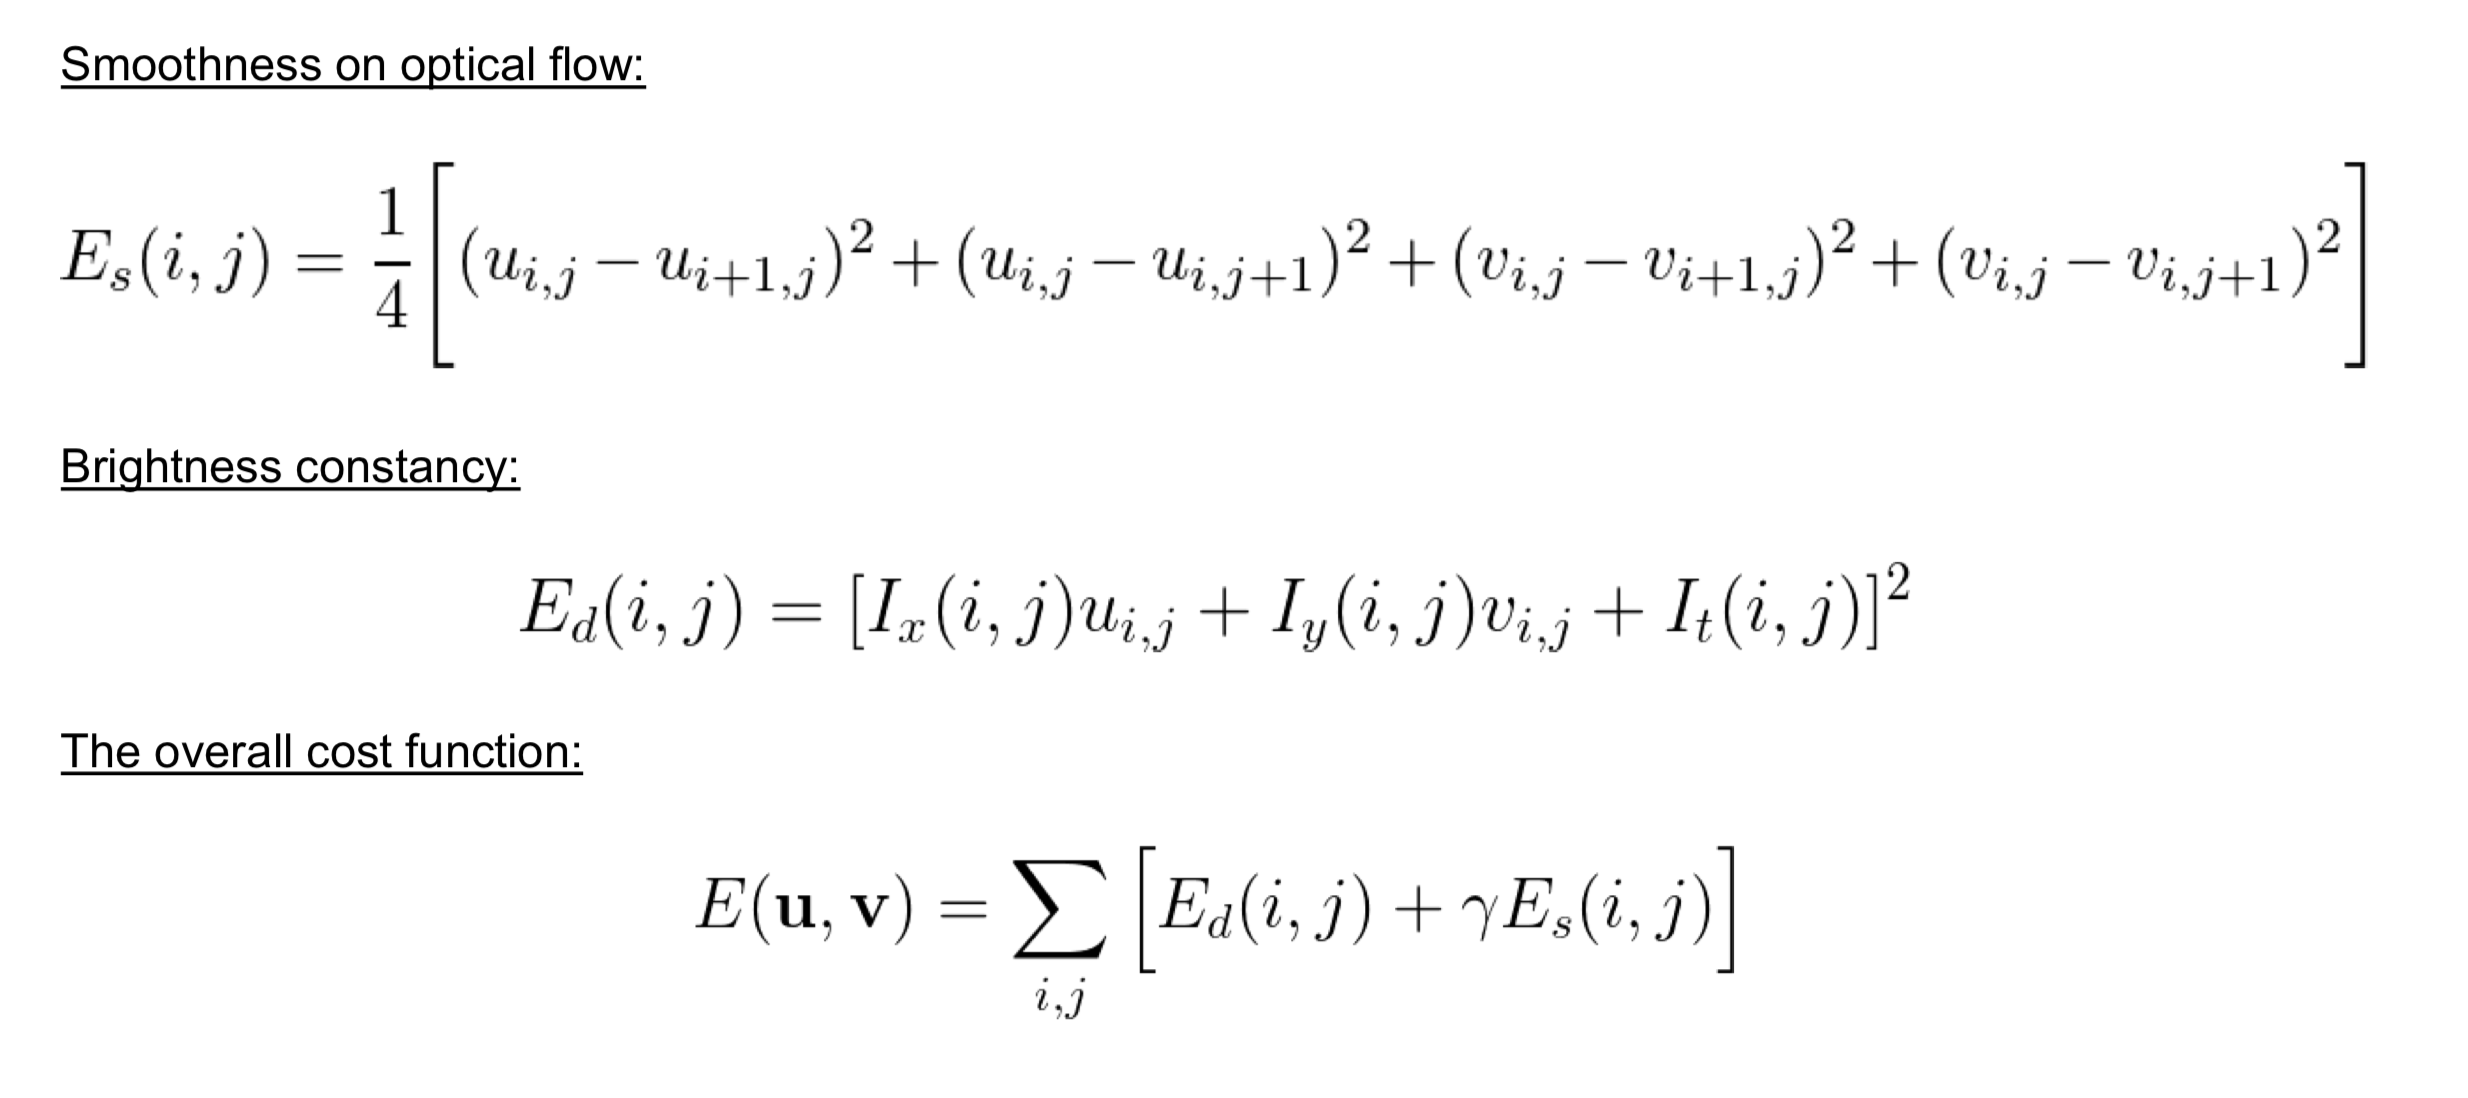

In [14]:
def horn_schunck(Ix, Iy, It, u, v, lamda):
    E = Eold = 0.0
    [rows, cols] = Ix.shape
    
    while True:
        
        # loop over all pixels
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                # compute vbar and ubar 
                ubar = (1/4) * (u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1])
                vbar = (1/4) * (v[i+1,j] + v[i-1,j] + v[i,j+1] + v[i,j-1])
                
                denominator = (lamda**2) + (Ix[i,j]** 2) + (Iy[i,j]** 2) 
                num_value = ((Ix[i,j]*ubar) + (Iy[i,j]*vbar) + It[i,j])
                
                # update u and v 
                u[i,j] = ubar - ((Ix[i,j] * num_value)/denominator)
                v[i,j] = vbar - ((Iy[i,j] * num_value)/denominator)
        
        # cost computation 
        Es = Ed = 0.0
        for i in range(1, rows-1):
            for j in range(1, cols-1):
                Es += (1/4)*((u[i,j]-u[i+1,j])**2 + (u[i,j]-u[i,j+1])**2 + (v[i,j]-v[i+1,j])**2 + (v[i,j]-v[i,j+1])**2)
                Ed += ((Ix[i,j]*u[i,j]) + (Iy[i,j]*v[i,j]) + It[i,j])**2
        E = Ed + (lamda*Es)
                
        # till converged
        # Check if value has not changed more than 1% of earlier value 
        difference = E - Eold if E > Eold else Eold - E
        threshold = 0.01*Eold 
        if (0 <= difference <= threshold):
            break
        else:
            Eold = E           

### Implemented on sphere using values of λ = 100, 10, 1, and 0.1 

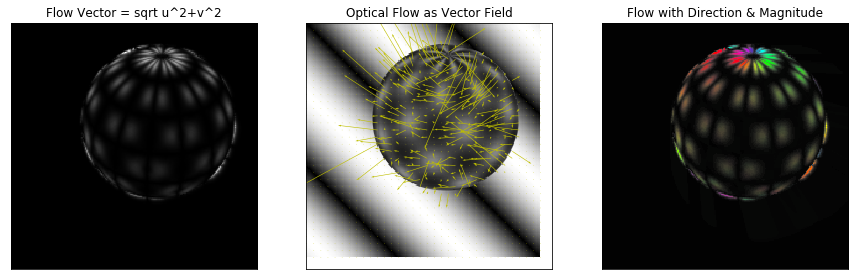

In [15]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
horn_schunck(sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 100)
flow_map (sphere0, sphere_u, sphere_v)

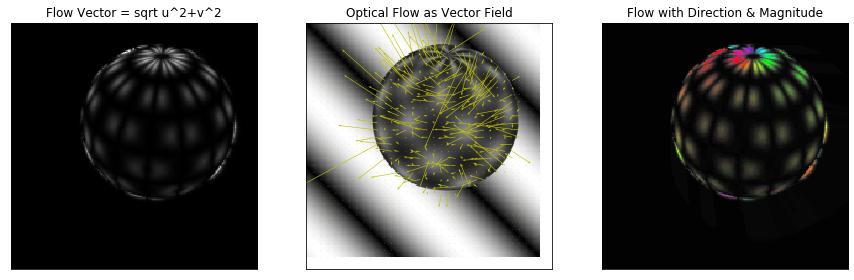

In [16]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
horn_schunck(sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 10)
flow_map (sphere0, sphere_u, sphere_v)

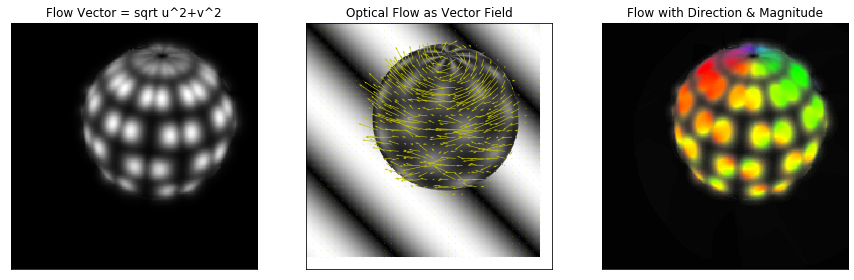

In [17]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
horn_schunck(sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 1)
flow_map (sphere0, sphere_u, sphere_v)

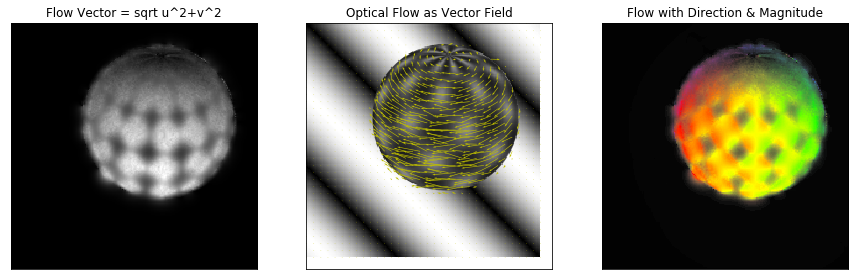

In [18]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
horn_schunck(sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 0.1)
flow_map (sphere0, sphere_u, sphere_v)

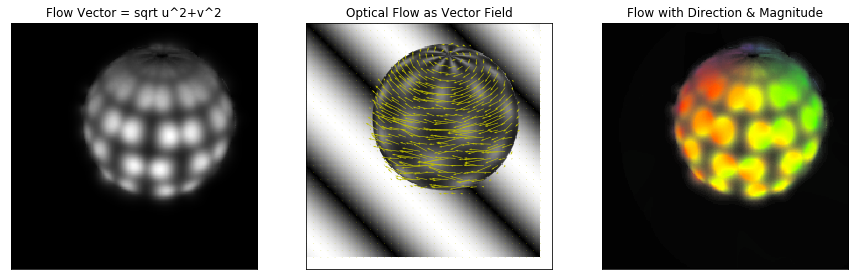

In [19]:
sphere_u = np.zeros(sphere0.shape)
sphere_v = np.zeros(sphere0.shape)
horn_schunck(sphere_x, sphere_y, sphere_t, sphere_u, sphere_v, 0.5)
flow_map (sphere0, sphere_u, sphere_v)

### Implementing on traffic data

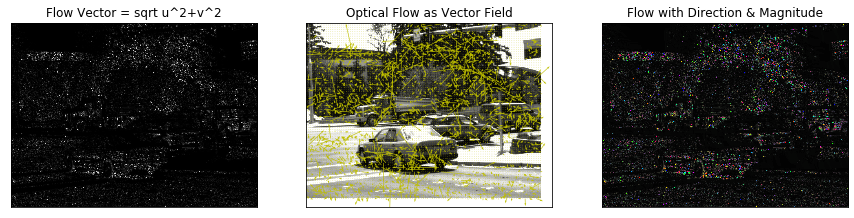

In [20]:
traffic_u = np.zeros(traffic0.shape)
traffic_v = np.zeros(traffic0.shape)
horn_schunck(traffic_x, traffic_y, traffic_t, traffic_u, traffic_v, 0.1)
flow_map (traffic0, traffic_u, traffic_v)

### Downsampling image before HS Method

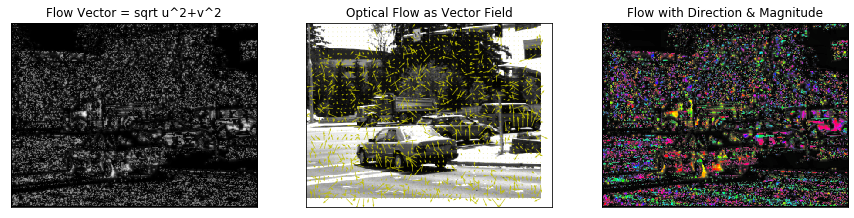

In [22]:
scale_percent = 50 
width = int(traffic0.shape[1] * scale_percent / 100)
height = int(traffic0.shape[0] * scale_percent / 100)
dim = (width, height)

traffic0_d = cv2.resize(traffic0, dim, interpolation = cv2.INTER_AREA)
traffic1_d = cv2.resize(traffic1, dim, interpolation = cv2.INTER_AREA)

traffic_x_d = xGradient(traffic0_d, traffic1_d)
traffic_y_d = yGradient(traffic0_d, traffic1_d)
traffic_t_d = np.subtract(traffic1_d, traffic0_d)

traffic_u = np.zeros(traffic0_d.shape)
traffic_v = np.zeros(traffic0_d.shape)
horn_schunck(traffic_x_d, traffic_y_d, traffic_t_d, traffic_u, traffic_v, 10)
flow_map (traffic0_d, traffic_u, traffic_v)

### Gaussian blur before HS Method

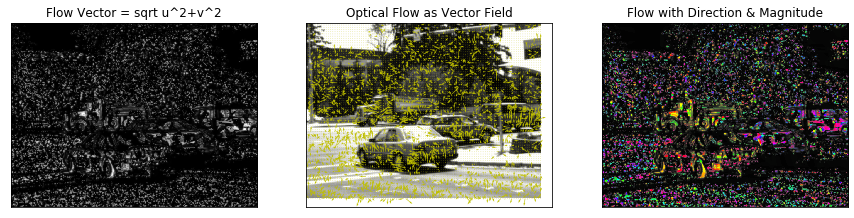

In [21]:
traffic0_b = cv2.GaussianBlur(traffic0, (5,5), 0)
traffic1_b = cv2.GaussianBlur(traffic1, (5,5), 0)

traffic_x_b = xGradient(traffic0_b, traffic1_b)
traffic_y_b = yGradient(traffic0_b, traffic1_b)
traffic_t_b = np.subtract(traffic1_b, traffic0_b)

traffic_u = np.zeros(traffic0_b.shape)
traffic_v = np.zeros(traffic0_b.shape)
horn_schunck(traffic_x_b, traffic_y_b, traffic_t_b, traffic_u, traffic_v, 10)
flow_map (traffic0_b, traffic_u, traffic_v)

### Downsampling plus Gaussian Blur

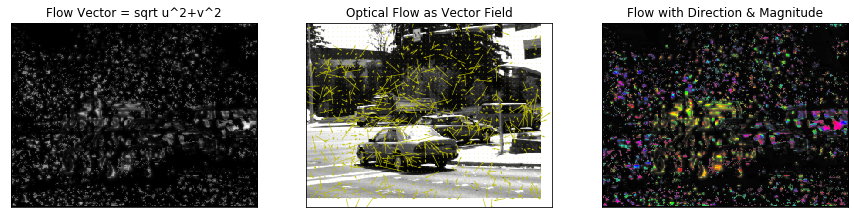

In [22]:
scale_percent = 50 
width = int(traffic0.shape[1] * scale_percent / 100)
height = int(traffic0.shape[0] * scale_percent / 100)
dim = (width, height)

traffic0_d = cv2.resize(traffic0, dim, interpolation = cv2.INTER_AREA)
traffic1_d = cv2.resize(traffic1, dim, interpolation = cv2.INTER_AREA)

traffic0_b = cv2.GaussianBlur(traffic0_d, (5,5), 0)
traffic1_b = cv2.GaussianBlur(traffic1_d, (5,5), 0)

traffic_x_b = xGradient(traffic0_b, traffic1_b)
traffic_y_b = yGradient(traffic0_b, traffic1_b)
traffic_t_b = np.subtract(traffic1_b, traffic0_b)

traffic_u = np.zeros(traffic0_b.shape)
traffic_v = np.zeros(traffic0_b.shape)
horn_schunck(traffic_x_b, traffic_y_b, traffic_t_b, traffic_u, traffic_v, 10)
flow_map (traffic0_d, traffic_u, traffic_v)

In [ ]:
def horn_schunck(Ix, Iy, It, u, v, lamda):
    E = Eold = 0.0
    [rows, cols] = Ix.shape
    
    while True:
        